The visualization used for this homework is based on Alexandr Verinov's code.  

# Generative models

In this homework we will try several criterions for learning an implicit model. We need to implement the objective for the game and play around with the model. 


**1)** Implement objective for a vanilla [Generative Adversarial Networks](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (GAN).

**2)** We see the discussion in the paper, that the objective for $G$ can be of two kinds: $min_G log(1 - D)$ and $min_G - log(D)$. We implement the second objective and ensure model converges. Most likely, in this example we will not notice the difference, but people usually use the second objective, it really matters in more complicated scenarios.

**3 & 4)** Implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([WGAN](https://arxiv.org/abs/1704.00028)) and WGAN-GP. To make the discriminator have Lipschitz property we need to clip discriminator's weights to $[-0.01, 0.01]$ range (WGAN) or use gradient penalty (WGAN-GP). We will need to make few modifications to the code: 1) remove sigmoids from discriminator 2) add weight clipping clipping / gradient penaly. 3) change objective. See [implementation 1](https://github.com/martinarjovsky/WassersteinGAN/) / [implementation 2](https://github.com/caogang/wgan-gp). They also use different optimizer. The default hyperparameters may not work, so we'll spend some time to tune them.

**5) Bonus: same thing without GANs** Implement maximum mean discrepancy estimator (MMD). MMD is discrepancy measure between distributions. In our case we use it to calculate discrepancy between real and fake data. You need to implement RBF kernel $k(x,x')=\exp \left(-{\frac  {1}{2\sigma ^{2}}}||x-x'||^{2}\right)$ and an MMD estimator (see eq.8 from https://arxiv.org/pdf/1505.03906.pdf). MMD is then used instead of discriminator.

In [ ]:
TASK = 1 # 2, 3, 4, 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imports

In [ ]:
import numpy as np
import time
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(12345)
lims=(-5, 5)

# Define sampler from real data and Z 

In [ ]:
from scipy.stats import rv_discrete

MEANS = np.array(
        [[-1,-3],
         [1,3],
         [-2,0],
        ])
COVS = np.array(
        [[[1,0.8],[0.8,1]],
        [[1,-0.5],[-0.5,1]],
        [[1,0],[0,1]],
        ])
PROBS = np.array([
        0.2,
        0.5,
        0.3
        ])
assert len(MEANS) == len(COVS) == len(PROBS), "number of components mismatch"
COMPONENTS = len(MEANS)

comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))

def sample_true(N):
    comps = comps_dist.rvs(size=N)
    conds = np.arange(COMPONENTS)[:,None] == comps[None,:]
    arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=N)
                     for c in range(COMPONENTS)])
    return np.select(conds[:,:,None], arr).astype(np.float32)

NOISE_DIM = 20
def sample_noise(N):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

# Visualization functions

In [ ]:
def vis_data(data):
    """
        Visualizes data as histogram
    """
    hist = np.histogram2d(data[:, 1], data[:, 0], bins=100, range=[lims, lims])
    plt.pcolormesh(hist[1], hist[2], hist[0], alpha=0.5)

fixed_noise = sample_noise(900)

def vis_g():
    """
        Visualizes generator's samples as circles
    """
    data = generator(Variable(torch.Tensor(fixed_noise).to(device))).cpu().data.numpy()
    if np.isnan(data).any():
        return
    
    plt.scatter(data[:,0], data[:,1], alpha=0.2, c='b')
    plt.xlim(lims)
    plt.ylim(lims)
    
def vis_d():
    """
        Visualizes discriminator's gradient on grid
    """
    X, Y = np.meshgrid(np.linspace(lims[0], lims[1], 30), np.linspace(lims[0], lims[1], 30))
    X = X.flatten()
    Y = Y.flatten()
    grid = Variable(torch.Tensor(np.vstack([X, Y]).T).to(device), requires_grad=True)
    data_gen = generator(Variable(torch.Tensor(fixed_noise).to(device)))
    loss = d_loss(discriminator(data_gen), discriminator(grid))
    loss.backward()
    grads = - grid.grad.cpu().data.numpy()
    plt.quiver(X, Y, grads[:, 0], grads[:, 1], color='black',alpha=0.9)

# Define architectures

After you've passed task 1 you can play with architectures.

#### Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z):
        """
            Generator takes a vector of noise and produces sample
        """
        h1 = F.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen

#### Discriminator(with sigmoid)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = F.sigmoid(self.fc4(h3))
        return score

# Define updates and losses

In [ ]:
generator = Generator(NOISE_DIM, out_dim = 2).to(device)
discriminator = Discriminator(in_dim = 2).to(device)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Notice we are using ADAM optimizer with `beta1=0.5` for both discriminator and discriminator. This is a common practice and works well. Motivation: models should be flexible and adapt itself rapidly to the distributions. 

You can try different optimizers and parameters.

In [ ]:
################################
# IMPLEMENT HERE
# Define the g_loss and d_loss here
# these are the only lines of code you need to change to implement GAN game

def g_loss(d_gen):
    if TASK == 1: 
        loss = torch.log1p(-d_gen).mean()
    elif TASK == 2:
        loss = -torch.log(d_gen).mean()
    elif TASK == 3 or TASK == 4:
        loss = -d_gen.mean()
    return loss

def d_loss(d_gen, d_real):
    if TASK == 1 or TASK == 2:
        loss = -(torch.log(d_real) + torch.log1p(-d_gen)).mean()
    elif TASK == 3 or TASK == 4:
        loss = (-d_real + d_gen).mean()
    return loss
################################

# Get real data

In [ ]:
data = sample_true(100000)
def iterate_minibatches(X, batchsize, y=None):
    perm = np.random.permutation(X.shape[0])
    
    for start in range(0, X.shape[0], batchsize):
        end = min(start + batchsize, X.shape[0])
        if y is None:
            yield X[perm[start:end]]
        else:
            yield X[perm[start:end]], y[perm[start:end]]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


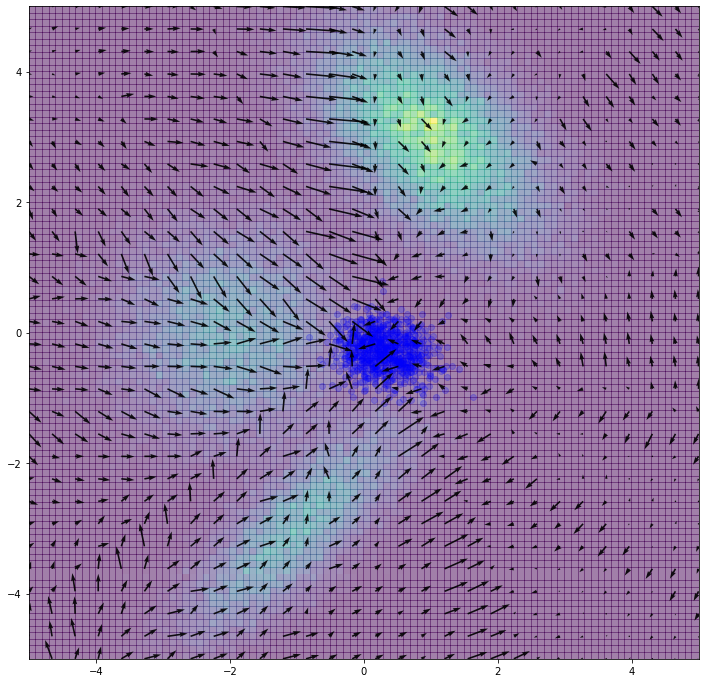

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
vis_d()

**Legend**:
- Blue dots are generated samples. 
- Colored histogram at the back shows density of real data. 
- And with arrows we show gradients of the discriminator -- they are the directions that discriminator pushes generator's samples. 

# Train the model

## Task 1

In [ ]:
TASK = 1

In [ ]:
generator = Generator(NOISE_DIM, out_dim = 2).to(device)
discriminator = Discriminator(in_dim = 2).to(device)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

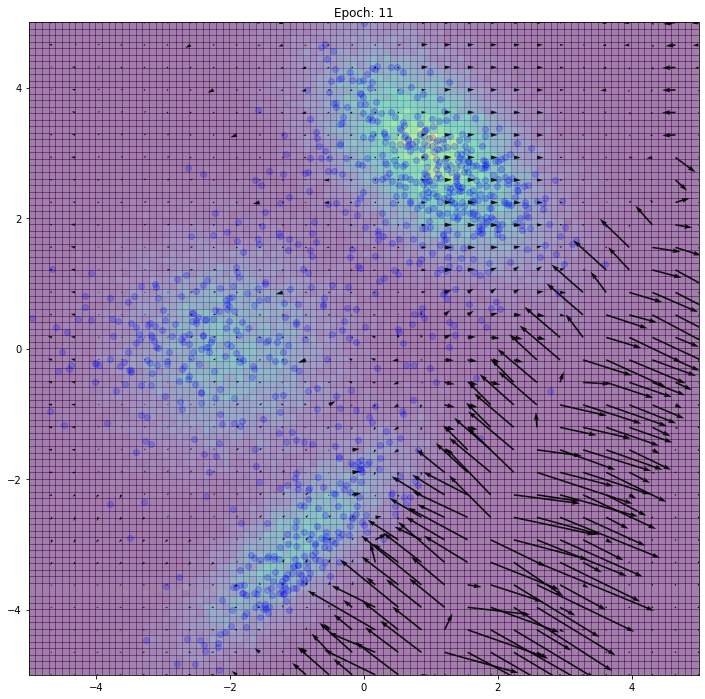

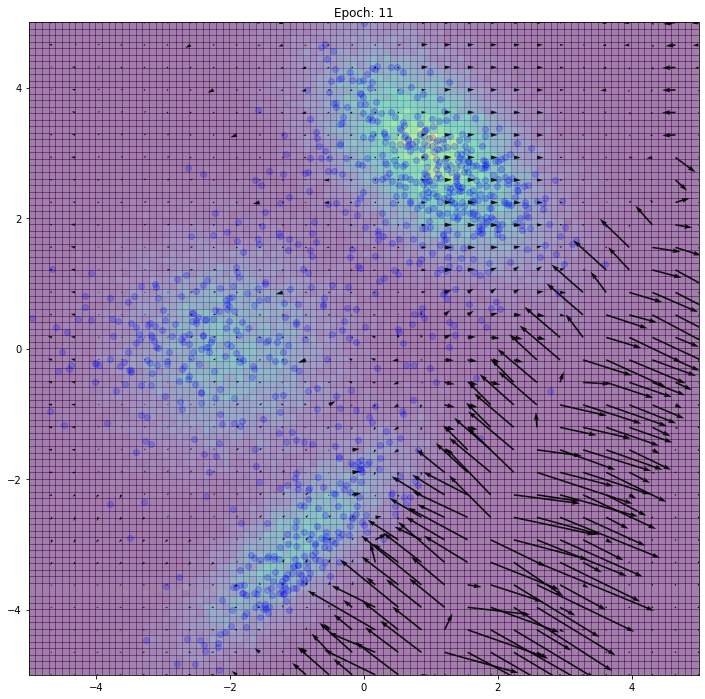

In [ ]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 14
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data)).to(device)
                data_gen = generator(noise)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
        # Visualize
        plt.clf()
        vis_data(data); vis_g(); vis_d()
        display.clear_output(wait=True)
        plt.title(f'Epoch: {epoch}')
        display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

**Наблюдения:**
> * Интересно отметить поведение GAN-а во время процесса оптимизации.
> * В начале генерируемое распределение представляло собой сконцентрированное в центре облако точек.
> * Затем критик заставил генератора его равномерно раздуть по всему полю, а после этого начал собирать точки в искомые "кучки".
> * Сходимость наступила за 11 эпох.

## Task 2

In [ ]:
TASK = 2

In [ ]:
generator = Generator(NOISE_DIM, out_dim = 2).to(device)
discriminator = Discriminator(in_dim = 2).to(device)

lr = 0.001

g_optimizer = optim.Adam(generator.parameters(),     lr=lr, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

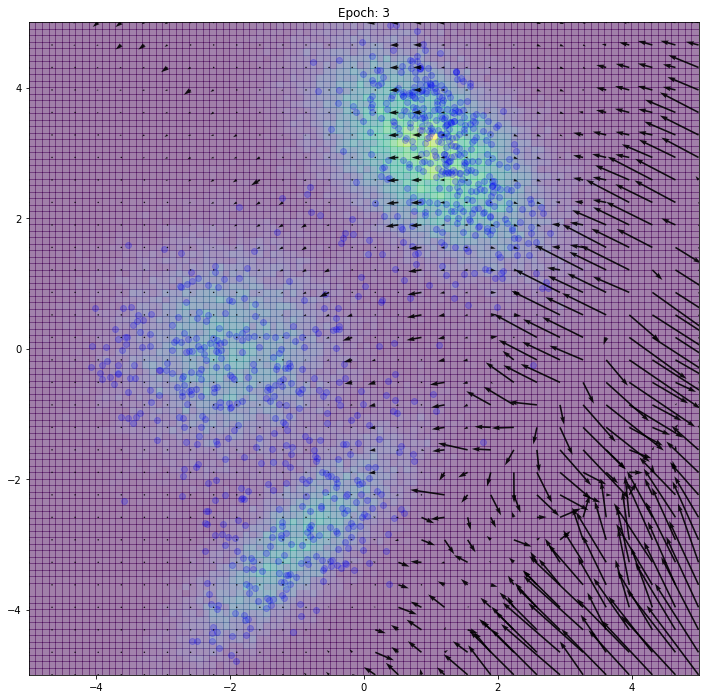

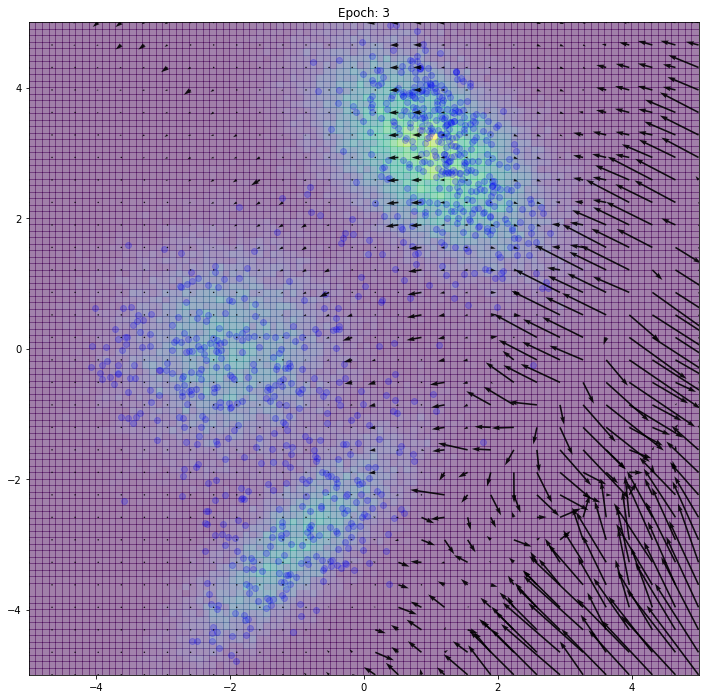

In [ ]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 15
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 4, 1

accs = []

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data)).to(device)
                data_gen = generator(noise)
                loss = d_loss(discriminator(data_gen), discriminator(inp_data))
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
        # Visualize
        plt.clf()
        vis_data(data); vis_g(); vis_d()
        display.clear_output(wait=True)
        plt.title(f'Epoch: {epoch}')
        display.display(plt.gcf())

        
except KeyboardInterrupt:
    pass

**Наблюдения:**
> * Поведение очень похоже на прошлый пункт, за исключением лишь может выбора порядка разделения прямыми.
> * Важнее другое: сходимость за **3 эпохи**.

## Task 3

In [ ]:
TASK = 3

Removing sigmoid:

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=300):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x):
        h1 = F.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = self.fc4(h3)
        return score

In [ ]:
generator = Generator(NOISE_DIM, out_dim = 2).to(device)
discriminator = Discriminator(in_dim = 2).to(device)

lr = 5e-4

g_optimizer = optim.RMSprop(generator.parameters(),     lr=lr)
d_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


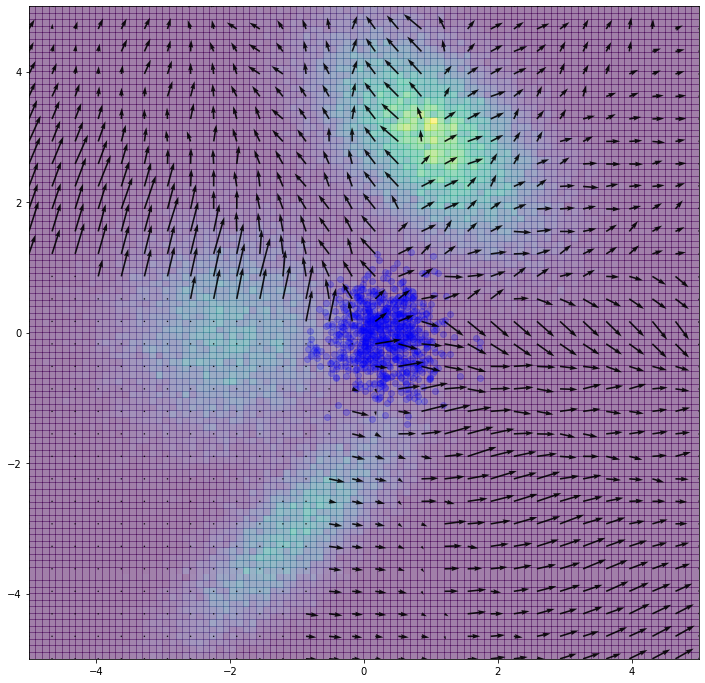

In [ ]:
plt.rcParams['figure.figsize'] = (12, 12)
vis_data(data)
vis_g()
vis_d()

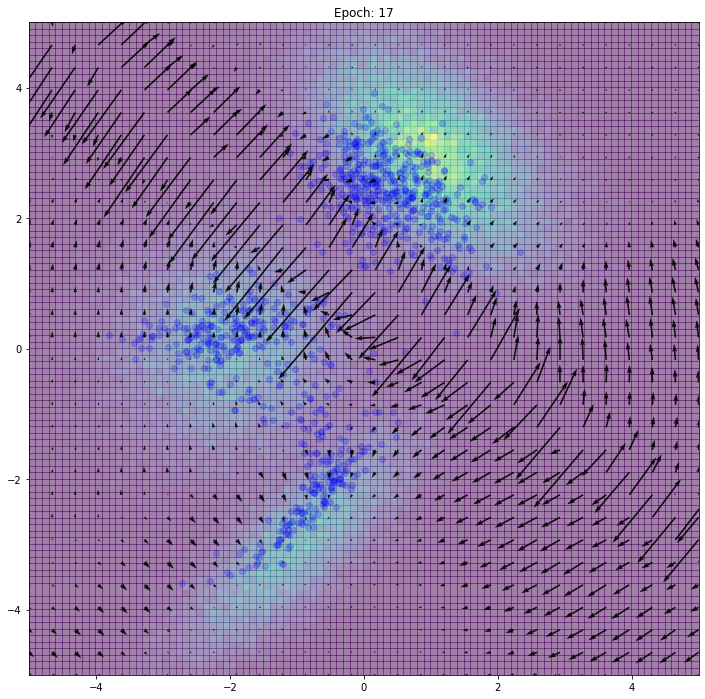

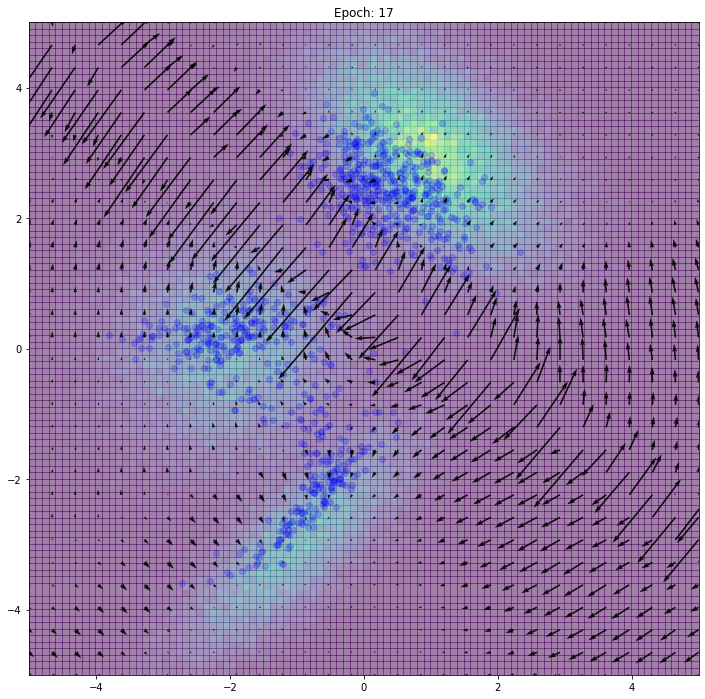

In [ ]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 30
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 5, 1

accs = []

class Clipper(object):
    def __init__(self, c=0.01):
        self.c = c

    def __call__(self, model):
        for p in model.parameters():
            p.data.clamp_(min=-self.c, max=self.c)

clipper = Clipper(0.01)

try:
    for epoch in range(num_epochs):
        for input_data in iterate_minibatches(data, batch_size):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data)).to(device)
                data_gen = generator(noise)
                d_gen = discriminator(data_gen)
                d_data = discriminator(inp_data)

                loss = d_loss(d_gen, d_data)
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()
                # Clipping
                clipper(discriminator)

    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
        # Visualize
        plt.clf()
        # plt.subplot(2, 1, 1)
        vis_data(data); vis_g(); vis_d()
        # plt.subplot(2, 1, 2)
        # plt.hist(d_gen.data.cpu().numpy())
        # plt.hist(d_data.data.cpu().numpy(), color='orange')
        display.clear_output(wait=True)
        plt.title(f'Epoch: {epoch}')
        display.display(plt.gcf())
        
except KeyboardInterrupt:
    pass

**Наблюдения:**
> * Самая главная особенность `WGAN` это форма градиентов. Как и упоминается в статье, "The critic, however, can’t saturate, and converges to a linear function that gives
remarkably clean gradients everywhere", то есть наблюдаем прямолинейные "желобы". 
> * Сошлось за 17 эпох.

## Task 4

In [ ]:
TASK = 4

In [ ]:
generator = Generator(NOISE_DIM, out_dim = 2).to(device)
discriminator = Discriminator(in_dim = 2).to(device)

lr = 1e-4

g_optimizer = optim.Adam(generator.parameters(),     lr=lr * 3, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

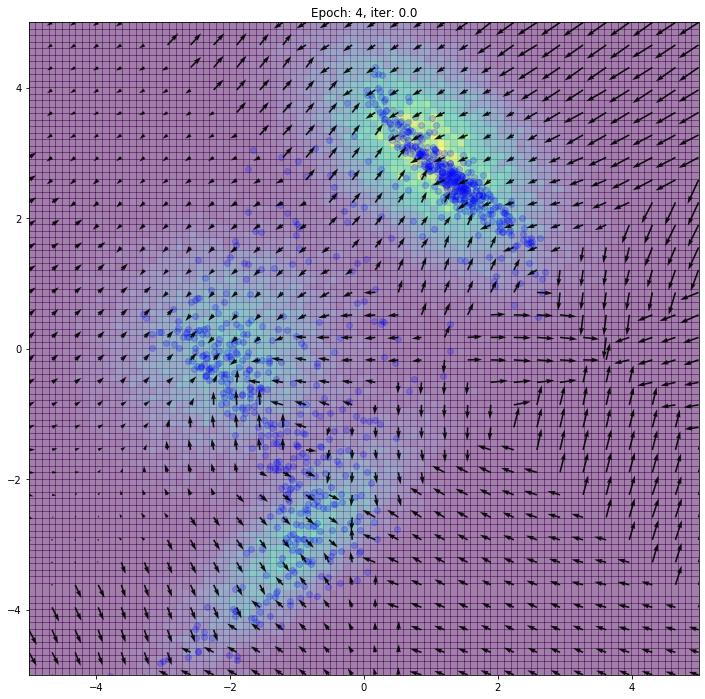

<Figure size 432x288 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

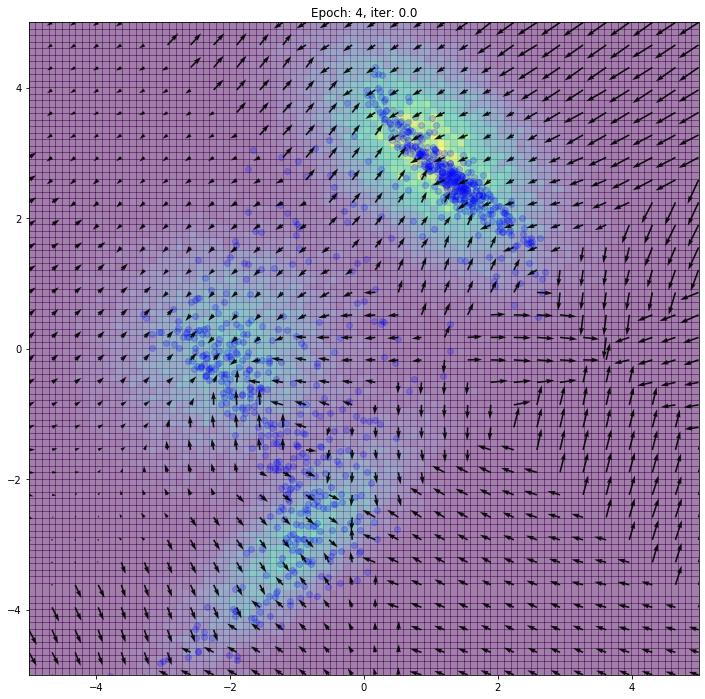

In [ ]:
from IPython import display

plt.xlim(lims)
plt.ylim(lims)

num_epochs = 100
batch_size = 64

# ===========================
# IMPORTANT PARAMETER:
# Number of D updates per G update
# ===========================
k_d, k_g = 5, 1
lam = 10
accs = []


def calc_gradient_penalty(discriminator, inp_data, data_gen, lam=10):
    alpha = torch.rand(inp_data.shape[0], 1).to(device)
   
    alpha.expand(inp_data.size())
    interpolates = alpha * inp_data  + (1 - alpha) * data_gen
   
    disc_interpolates = discriminator(interpolates)
   
    gradients = torch.autograd.grad(outputs=disc_interpolates,
                              inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              only_inputs=True,
                              create_graph=True,
                              retain_graph=True,)[0]
   
    penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lam
    return penalty


try:
    for epoch in range(num_epochs):
        for i, input_data in enumerate(iterate_minibatches(data, batch_size)):
            
            # Optimize D
            for _ in range(k_d):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                inp_data = Variable(torch.Tensor(input_data)).to(device)
                data_gen = generator(noise)
                d_gen = discriminator(data_gen)
                d_data = discriminator(inp_data)

                loss = d_loss(d_gen, d_data)
                loss += calc_gradient_penalty(discriminator, inp_data, data_gen, lam=lam)
                
                d_optimizer.zero_grad()
                loss.backward()
                d_optimizer.step()

    
            # Optimize G
            for _ in range(k_g):
                # Sample noise
                noise = Variable(torch.Tensor(sample_noise(len(input_data)))).to(device)
                
                # Do an update
                data_gen = generator(noise)
                loss = g_loss(discriminator(data_gen))
                g_optimizer.zero_grad()
                loss.backward()
                g_optimizer.step()
            
            if i == 0:
                # Visualize
                plt.clf()
                plt.figure(figsize=(12, 12))
                vis_data(data); vis_g(); vis_d()
                display.clear_output(wait=True)
                plt.title(f'Epoch: {epoch}, iter: {i/300}')
                display.display(plt.gcf())
        
except KeyboardInterrupt:
    pass

**Наблюдения:**
> * Самая стабильная из всех сетей, что подтверждает слова авторов статьи: "We find our method results in more stable gradients that
neither vanish nor explode, allowing training of more complicated networks".
> * Сходимость наступила за 4 эпохи.